In [1]:
!pip install --user --upgrade --editable gym-env

Obtaining file:///C:/Users/singh/Documents/Foraging_DRL_Project/gym-env
  Attempting uninstall: gym-env
    Found existing installation: gym-env 1.0.0
    Uninstalling gym-env-1.0.0:
      Successfully uninstalled gym-env-1.0.0
  Running setup.py develop for gym-env


# Restart Kernel

In [11]:
import gym
from gym import spaces
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import sys 

In [12]:
params={}
params["maxEpisodes"]=1000
params["epsilon"]=0.3
params["initial_epsilon"]=1.0
params["final_epsilon"]={}
params["decay_rate"]={}
params["final_epsilon"]['lin']=0.0
params["final_epsilon"]['exp']=0.01
params["decay_rate"]['lin']=(params["initial_epsilon"]-params["final_epsilon"]['lin'])/params["maxEpisodes"]
params["decay_rate"]['exp']=np.log(params["initial_epsilon"]/params["final_epsilon"]['exp'])/params["maxEpisodes"]
params["c_UCB"]=0.1
params["init_temp"]=10000000
params["final_temp"]=0.05
params["temp_decay_rate_lin"]=(params["init_temp"]-params["final_temp"])/params["maxEpisodes"]
params["temp_decay_rate_exp"]=np.log(params["init_temp"]/params["final_temp"])/params["maxEpisodes"]
params["no_envs"]=50
params["decay_type_decaying_epsilon"]="lin"
params["decay_type_Softmax_exploration"]="exp"
params["arms"]=np.arange(1,16)

In [13]:
env = gym.make('gym_env:foraging-v101') #normal environment

In [14]:
def PureExploitation(env,params):
    # print("PureExploitation")
    Q = np.zeros(len(params["arms"])+1)
    N = np.zeros(len(params["arms"])+1)
    e = 0
    # print(len(params["arms"]))
    # print(len(N))
    Q_est = np.zeros((params["maxEpisodes"],len(params["arms"])+1))
    R=np.zeros((params["maxEpisodes"])-1)
    # actions=np.zeros((params["maxEpisodes"]))
    h = []
    env.reset()
    while e < params["maxEpisodes"]-1 :
        max_indices=np.where(Q==np.amax(Q))
        harvest = random.choice(max_indices[0])
        h.append(harvest)
        # harvest=9
        done=False
        r=0
        # print(harvest)
        while not done:
            for i in range (harvest):
                if not done:
                    end_state, reward, done= env.step(1)
                    # print(reward) 
                    r+=reward
            if not done:
                end_state, reward, done= env.step(0)
              
        # print(r)
        N[harvest] = N[harvest] + 1
        Q[harvest] = Q[harvest] + (r-Q[harvest])/N[harvest]
        
        
        R[e]=r
        e = e+1
        Q_est[e] = Q
        env.reset()
    return R,h

In [15]:
def PureExploration(env,params):
    # print("PureExploration")
    Q = np.zeros(len(params["arms"])+1)
    N = np.zeros(len(params["arms"])+1)
    e = 0
    # print(len(params["arms"]))
    # print(len(N))
    Q_est = np.zeros((params["maxEpisodes"],len(params["arms"])+1))
    R=np.zeros((params["maxEpisodes"])-1)
    # actions=np.zeros((params["maxEpisodes"]))
    env.reset()
    h = []
    while e < params["maxEpisodes"]-1 :
        harvest= random.choice(np.arange(1,len(Q)))
        h.append(harvest)
        # print(harvest)
        done=False
        r=0
        while not done:
            for i in range (harvest):
                if not done:
                    end_state, reward, done = env.step(1)
                    r+=reward
            if not done:
                end_state, reward, done= env.step(0)
        #     print(r,reward)   
        # print(r)
        N[harvest] = N[harvest] + 1
        Q[harvest] = Q[harvest] + (r-Q[harvest])/N[harvest]
        
        
        R[e]=r
        e = e+1
        Q_est[e] = Q
        env.reset()
    return R,h

In [16]:
def epsilonGreedy(env,params):
    # print("epsilonGreedy")
    Q = np.zeros(len(params["arms"])+1)
    N = np.zeros(len(params["arms"])+1)
    e = 0
    # print(len(params["arms"]))
    # print(len(N))
    Q_est = np.zeros((params["maxEpisodes"],len(params["arms"])+1))
    R=np.zeros((params["maxEpisodes"])-1)
    # actions=np.zeros((params["maxEpisodes"]))
    env.reset()
    h = []
    while e < params["maxEpisodes"]-1 :
        if random.random() > params["epsilon"]:
            max_indices=np.where(Q==np.amax(Q))
            harvest = random.choice(max_indices[0])
        else :
            harvest= random.choice(np.arange(1,len(Q)+1))
        # print(harvest)
        h.append(harvest)
        done=False
        r=0
        while not done:
            for i in range (harvest):
                if not done:
                    end_state, reward, done= env.step(1)
                    r+=reward
            if not done:
                end_state, reward, done = env.step(0)
        #     print(r,reward)   
        # print(r)
        N[harvest-1] = N[harvest-1] + 1
        Q[harvest-1] = Q[harvest-1] + (r-Q[harvest-1])/N[harvest-1]
        
        
        R[e]=r
        e = e+1
        Q_est[e] = Q
        env.reset()
    return R,h


In [17]:
def decayingEpsilonGreedy(env,params,type):
    # print("decayingEpsilonGreedy")
    Q = np.zeros(len(params["arms"])+1)
    N = np.zeros(len(params["arms"])+1)
    e = 0
    # print(len(params["arms"]))
    # print(len(N))
    Q_est = np.zeros((params["maxEpisodes"],len(params["arms"])+1))
    R=np.zeros((params["maxEpisodes"])-1)
    # actions=np.zeros((params["maxEpisodes"]))
    env.reset()
    h = []
    epsilon=params["initial_epsilon"]
    while e < params["maxEpisodes"]-1 :
        if random.random() > epsilon:
            max_indices=np.where(Q==np.amax(Q))
            # print(epsilon,e,max_indices[0])
            harvest = random.choice(max_indices[0])
        else :
            harvest= random.choice(np.arange(1,len(Q)))
        # print(harvest)
        h.append(harvest)
        done=False
        r=0
        while not done:
            for i in range (harvest):
                if not done:
                    end_state, reward, done = env.step(1)
                    r+=reward
            if not done:
                end_state, reward, done = env.step(0)
        #     print(r,reward)   
        # print(r)
        N[harvest] = N[harvest] + 1
        Q[harvest] = Q[harvest] + (r-Q[harvest])/N[harvest]
        
        if type=='lin':
            epsilon=epsilon-params["decay_rate"]['lin']
        else :
            epsilon = epsilon*np.exp(-params["decay_rate"]['exp'])
            
        R[e]=r
        e = e+1
        Q_est[e] = Q
        env.reset()
    return R,h


In [18]:
def UCBexploration(env,params):
    # print("UCBexploration")
    Q = np.zeros(len(params["arms"])+1)
    N = np.zeros(len(params["arms"])+1)
    e = 0
    # print(len(params["arms"]))
    # print(len(N))
    Q_est = np.zeros((params["maxEpisodes"],len(params["arms"])+1))
    R=np.zeros((params["maxEpisodes"])-1)
    # actions=np.zeros((params["maxEpisodes"]))
    env.reset()
    h = []
    while e < params["maxEpisodes"] - 1:
        if e< len(params["arms"]):
            harvest = e+1
        else:
            # if e==51:
            #     print(N)
            U= params["c_UCB"]* math.sqrt(math.log(e))/np.sqrt(N)
            UCB = np.add(Q,U)
            max_indices=np.where(UCB==np.amax(UCB))
            harvest = random.choice(max_indices[0])
            # N[harvest] = N[harvest] + 1
        # print(harvest)
        h.append(harvest)
        done=False
        r=0
        while not done:
            for i in range (harvest):
                if not done:
                    end_state, reward, done = env.step(1)
                    r+=reward
            if not done:
                end_state, reward, done = env.step(0)
        # print(r)
        N[harvest] = N[harvest] + 1
        Q[harvest] = Q[harvest] + (r-Q[harvest])/N[harvest]
        R[e] =r
        e = e+1
        Q_est[e] = Q
        
        
        env.reset()
    return R,h


In [24]:
exploit = []
explore = []
epsilon = []
depsilon = []
ucb = []
exploith = []
exploreh= []
epsilonh = []
depsilonh = []
ucbh = []
for i in range(50):
    env = gym.make('gym_env:foraging-v101') #normal environment
    env.seed(i+50)
    random.seed(i+50)
    r1 = PureExploitation(env,params)
    r2 = PureExploration(env,params)
    r3 = epsilonGreedy(env,params)
    r4 = decayingEpsilonGreedy(env,params,"exp")
    r6 = UCBexploration(env,params)
    r1,h1 = PureExploitation(env,params)
    r2,h2 = PureExploration(env,params)
    r3,h3 = epsilonGreedy(env,params)
    r4,h4 = decayingEpsilonGreedy(env,params,"exp")
    r6,h6 = UCBexploration(env,params)
    
    exploit.append(r1)
    explore.append(r2)
    epsilon.append(r3)
    depsilon.append(r4)
    ucb.append(r6)
    exploith.append(h1)
    exploreh.append(h2)
    epsilonh.append(h3)
    depsilonh.append(h4)
    ucbh.append(h6)

    

<ipython-input-18-d1681849d38a>:19: RuntimeWarning: divide by zero encountered in true_divide
  U= params["c_UCB"]* math.sqrt(math.log(e))/np.sqrt(N)


In [25]:
exploit = np.array(exploit)
explore = np.array(explore)
epsilon = np.array(epsilon)
depsilon = np.array(depsilon)
ucb = np.array(ucb)
exploith = np.array(exploith)
exploreh= np.array(exploreh)
epsilonh = np.array(epsilonh)
depsilonh = np.array(depsilonh)
ucbh = np.array(ucbh)
# print(np.shape(exploith))

avg1 = np.average(exploit,axis=0)
avg2 = np.average(explore,axis=0)
avg3 = np.average(epsilon,axis=0)
avg4 = np.average(depsilon,axis=0)
avg6 = np.average(ucb,axis=0)
avg1h = np.average(exploith,axis=0)
avg2h = np.average(exploreh,axis=0)
avg3h = np.average(epsilonh,axis=0)
avg4h = np.average(depsilonh,axis=0)
avg6h = np.average(ucbh,axis=0)
avg1h=np.round(avg1h,0)
avg2h=np.round(avg2h,0)
avg3h=np.round(avg3h,0)
avg4h=np.round(avg4h,0)
avg6h=np.round(avg6h,0)
x = np.arange(params["maxEpisodes"]-1)

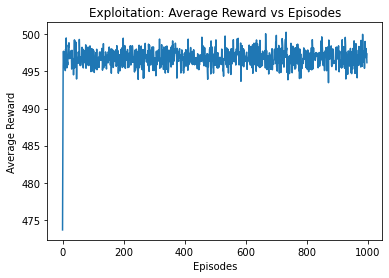

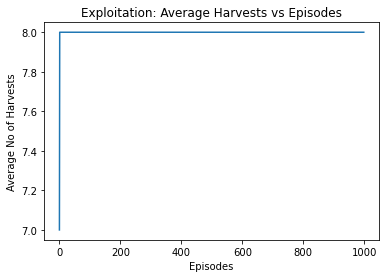

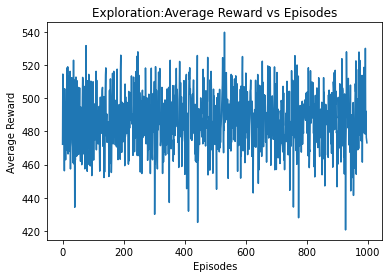

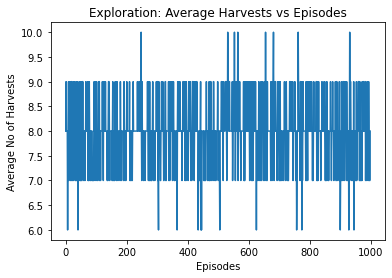

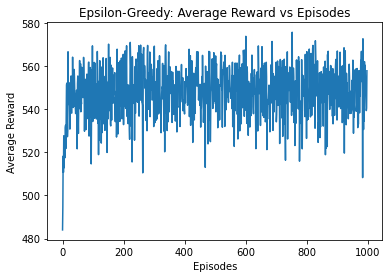

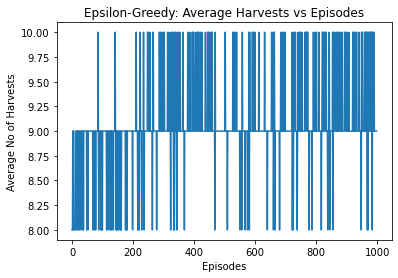

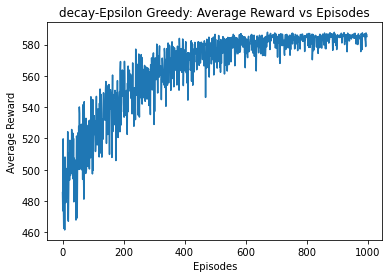

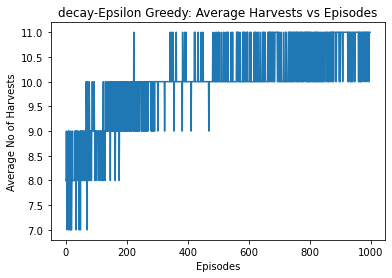

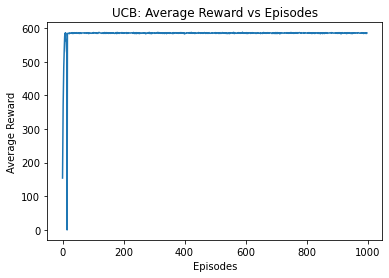

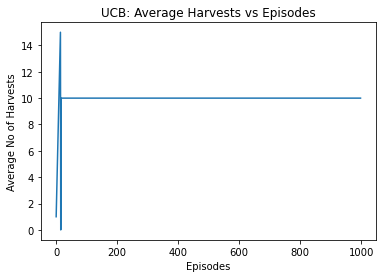

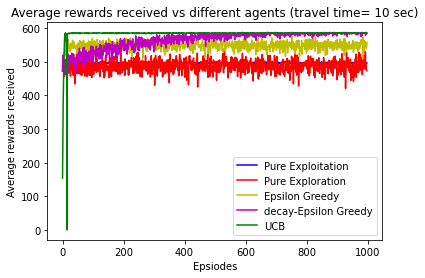

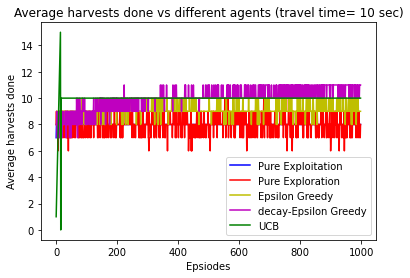

In [27]:
plt.plot(x,avg1)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Exploitation: Average Reward vs Episodes")
plt.savefig('exploit rewards10.pdf')
plt.show()
plt.close()

plt.plot(x,avg1h)
plt.xlabel("Episodes")
plt.ylabel("Average No of Harvests")
plt.title("Exploitation: Average Harvests vs Episodes")
plt.savefig('exploit harvest10.pdf')
plt.show()
plt.close()

plt.plot(x,avg2)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Exploration:Average Reward vs Episodes")
plt.savefig('explore rewards10.pdf')
plt.show()
plt.close()

plt.plot(x,avg2h)
plt.xlabel("Episodes")
plt.ylabel("Average No of Harvests")
plt.title("Exploration: Average Harvests vs Episodes")
plt.savefig('explore harvest10.pdf')
plt.show()
plt.close()

plt.plot(x,avg3)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Epsilon-Greedy: Average Reward vs Episodes")
plt.savefig('epsilon rewards10.pdf')
plt.show()
plt.close()

plt.plot(x,avg3h)
plt.xlabel("Episodes")
plt.ylabel("Average No of Harvests")
plt.title("Epsilon-Greedy: Average Harvests vs Episodes")
plt.savefig('epsilon harvest10.pdf')
plt.show()
plt.close()

plt.plot(x,avg4)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("decay-Epsilon Greedy: Average Reward vs Episodes")
plt.savefig('depsilon rewards10.pdf') 
plt.show()
plt.close()

plt.plot(x,avg4h)
plt.xlabel("Episodes")
plt.ylabel("Average No of Harvests")
plt.title("decay-Epsilon Greedy: Average Harvests vs Episodes")
plt.savefig('depsilon harvest10.pdf')
plt.show()
plt.close()

plt.plot(x,avg6)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("UCB: Average Reward vs Episodes")
plt.savefig('ucb rewards10.pdf')
plt.show()
plt.close()

plt.plot(x,avg6h)
plt.xlabel("Episodes")
plt.ylabel("Average No of Harvests")
plt.title("UCB: Average Harvests vs Episodes")
plt.savefig('UCB harvest10.pdf')
plt.show()
plt.close()

plt.plot(x,avg1,'b')
plt.plot(x,avg2,'r')
plt.plot(x,avg3,'y')
plt.plot(x,avg4,'m')
plt.plot(x,avg6,'g')
plt.title("Average rewards received vs different agents (travel time= 10 sec)")
plt.xlabel("Epsiodes")
plt.ylabel("Average rewards received")
plt.legend(["Pure Exploitation","Pure Exploration","Epsilon Greedy","decay-Epsilon Greedy","UCB"], loc = "lower right")
plt.savefig("10 Average rewards received vs different agents.pdf")
plt.show()
plt.close()

plt.plot(x,avg1h,'b')
plt.plot(x,avg2h,'r')
plt.plot(x,avg3h,'y')
plt.plot(x,avg4h,'m')
plt.plot(x,avg6h,'g')
plt.title("Average harvests done vs different agents (travel time= 10 sec)")
plt.xlabel("Epsiodes")
plt.ylabel("Average harvests done")
plt.legend(["Pure Exploitation","Pure Exploration","Epsilon Greedy","decay-Epsilon Greedy","UCB"], loc = "lower right")
plt.savefig("10 Average harvests done vs different agents.pdf")
plt.show()
plt.close()

In [28]:
exploit = []
explore = []
epsilon = []
depsilon = []
ucb = []
exploith = []
exploreh= []
epsilonh = []
depsilonh = []
ucbh = []
for i in range(50):
    env = gym.make('gym_env:foraging-v101',interval_time = 3) #normal environment
    env.seed(i+50)
    random.seed(i+50)
    r1 = PureExploitation(env,params)
    r2 = PureExploration(env,params)
    r3 = epsilonGreedy(env,params)
    r4 = decayingEpsilonGreedy(env,params,"exp")
    r6 = UCBexploration(env,params)
    r1,h1 = PureExploitation(env,params)
    r2,h2 = PureExploration(env,params)
    r3,h3 = epsilonGreedy(env,params)
    r4,h4 = decayingEpsilonGreedy(env,params,"exp")
    r6,h6 = UCBexploration(env,params)
    
    exploit.append(r1)
    explore.append(r2)
    epsilon.append(r3)
    depsilon.append(r4)
    ucb.append(r6)
    exploith.append(h1)
    exploreh.append(h2)
    epsilonh.append(h3)
    depsilonh.append(h4)
    ucbh.append(h6)

    

<ipython-input-18-d1681849d38a>:19: RuntimeWarning: divide by zero encountered in true_divide
  U= params["c_UCB"]* math.sqrt(math.log(e))/np.sqrt(N)


In [29]:
exploit = np.array(exploit)
explore = np.array(explore)
epsilon = np.array(epsilon)
depsilon = np.array(depsilon)
ucb = np.array(ucb)
exploith = np.array(exploith)
exploreh= np.array(exploreh)
epsilonh = np.array(epsilonh)
depsilonh = np.array(depsilonh)
ucbh = np.array(ucbh)
# print(np.shape(exploith))

avg1 = np.average(exploit,axis=0)
avg2 = np.average(explore,axis=0)
avg3 = np.average(epsilon,axis=0)
avg4 = np.average(depsilon,axis=0)
avg6 = np.average(ucb,axis=0)
avg1h = np.average(exploith,axis=0)
avg2h = np.average(exploreh,axis=0)
avg3h = np.average(epsilonh,axis=0)
avg4h = np.average(depsilonh,axis=0)
avg6h = np.average(ucbh,axis=0)
avg1h=np.round(avg1h,0)
avg2h=np.round(avg2h,0)
avg3h=np.round(avg3h,0)
avg4h=np.round(avg4h,0)
avg6h=np.round(avg6h,0)
x = np.arange(params["maxEpisodes"]-1)

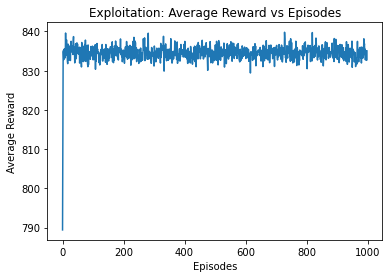

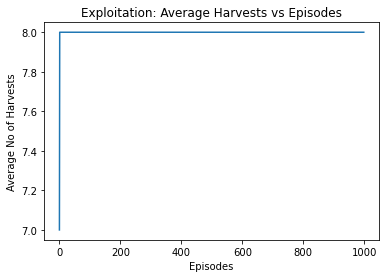

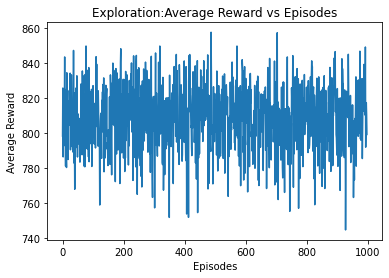

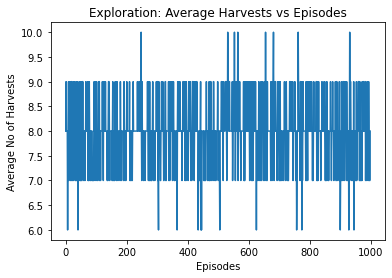

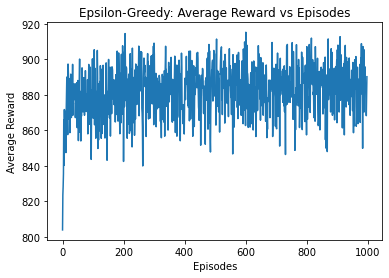

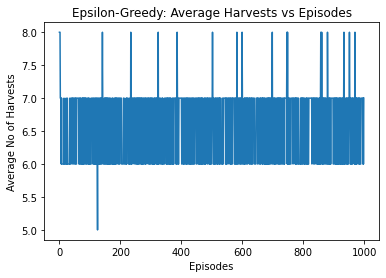

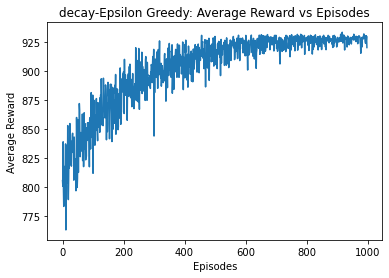

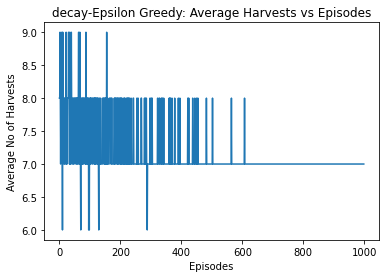

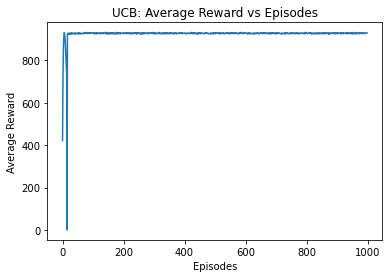

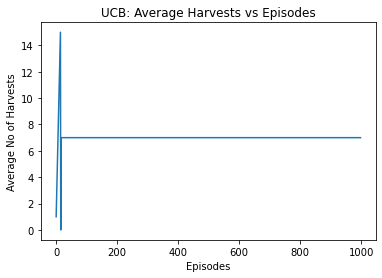

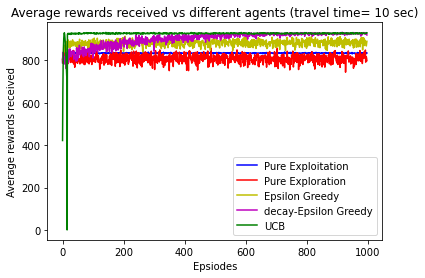

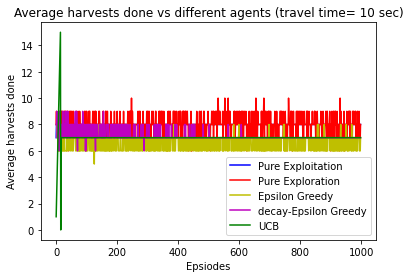

In [30]:
plt.plot(x,avg1)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Exploitation: Average Reward vs Episodes")
plt.savefig('exploit rewards3.pdf')
plt.show()
plt.close()

plt.plot(x,avg1h)
plt.xlabel("Episodes")
plt.ylabel("Average No of Harvests")
plt.title("Exploitation: Average Harvests vs Episodes")
plt.savefig('exploit harvest3.pdf')
plt.show()
plt.close()

plt.plot(x,avg2)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Exploration:Average Reward vs Episodes")
plt.savefig('explore rewards3.pdf')
plt.show()
plt.close()

plt.plot(x,avg2h)
plt.xlabel("Episodes")
plt.ylabel("Average No of Harvests")
plt.title("Exploration: Average Harvests vs Episodes")
plt.savefig('explore harvest3.pdf')
plt.show()
plt.close()

plt.plot(x,avg3)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Epsilon-Greedy: Average Reward vs Episodes")
plt.savefig('epsilon rewards3.pdf')
plt.show()
plt.close()

plt.plot(x,avg3h)
plt.xlabel("Episodes")
plt.ylabel("Average No of Harvests")
plt.title("Epsilon-Greedy: Average Harvests vs Episodes")
plt.savefig('epsilon harvest3.pdf')
plt.show()
plt.close()

plt.plot(x,avg4)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("decay-Epsilon Greedy: Average Reward vs Episodes")
plt.savefig('depsilon rewards3.pdf') 
plt.show()
plt.close()

plt.plot(x,avg4h)
plt.xlabel("Episodes")
plt.ylabel("Average No of Harvests")
plt.title("decay-Epsilon Greedy: Average Harvests vs Episodes")
plt.savefig('depsilon harvest3.pdf')
plt.show()
plt.close()

plt.plot(x,avg6)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("UCB: Average Reward vs Episodes")
plt.savefig('ucb rewards3.pdf')
plt.show()
plt.close()

plt.plot(x,avg6h)
plt.xlabel("Episodes")
plt.ylabel("Average No of Harvests")
plt.title("UCB: Average Harvests vs Episodes")
plt.savefig('UCB harvest3.pdf')
plt.show()
plt.close()

plt.plot(x,avg1,'b')
plt.plot(x,avg2,'r')
plt.plot(x,avg3,'y')
plt.plot(x,avg4,'m')
plt.plot(x,avg6,'g')
plt.title("Average rewards received vs different agents (travel time= 10 sec)")
plt.xlabel("Epsiodes")
plt.ylabel("Average rewards received")
plt.legend(["Pure Exploitation","Pure Exploration","Epsilon Greedy","decay-Epsilon Greedy","UCB"], loc = "lower right")
plt.savefig("3 Average rewards received vs different agents.pdf")
plt.show()
plt.close()

plt.plot(x,avg1h,'b')
plt.plot(x,avg2h,'r')
plt.plot(x,avg3h,'y')
plt.plot(x,avg4h,'m')
plt.plot(x,avg6h,'g')
plt.title("Average harvests done vs different agents (travel time= 10 sec)")
plt.xlabel("Epsiodes")
plt.ylabel("Average harvests done")
plt.legend(["Pure Exploitation","Pure Exploration","Epsilon Greedy","decay-Epsilon Greedy","UCB"], loc = "lower right")
plt.savefig("3 Average harvests done vs different agents.pdf")
plt.show()
plt.close()